In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

# Analysis of cancer types per cell line

In [2]:
# Model dataset : DepMap 24Q4 Model.csv
model_file_path = "inputs/Model.csv"
model = pd.read_csv(model_file_path)

# Expression data extracted from the R code
expression_file_path = "inputs/expression_populations_SMARCA4_CDAN1.csv"
expression_populations = pd.read_csv(expression_file_path)

In [3]:
full_dataset = pd.merge(left=expression_populations, right=model, how="left", left_on="line", right_on="ModelID")

full_dataset = full_dataset[["line", "CellLineName", "population", "OncotreePrimaryDisease", "OncotreeLineage"]]

print(full_dataset)

           line CellLineName population  \
0    ACH-001098     KCI-MOH1        low   
1    ACH-000570         YKG1       high   
2    ACH-000769         LK-2       high   
3    ACH-000123       COV434        low   
4    ACH-001536      KKU-100        low   
..          ...          ...        ...   
190  ACH-000666    NCI-H1355        low   
191  ACH-000872       HCC515        low   
192  ACH-000781    NCI-H2023        low   
193  ACH-000402        BL-70       high   
194  ACH-000052        A-673       high   

                              OncotreePrimaryDisease       OncotreeLineage  
0                          Pancreatic Adenocarcinoma              Pancreas  
1                                     Diffuse Glioma             CNS/Brain  
2                         Non-Small Cell Lung Cancer                  Lung  
3                           Ovarian Epithelial Tumor  Ovary/Fallopian Tube  
4    Intraductal Papillary Neoplasm of the Bile Duct         Biliary Tract  
..                   

In [4]:
# Count occurrences
counts = full_dataset['OncotreePrimaryDisease'].value_counts()

# Compute percentages
model_percentages = counts / counts.sum() * 100

# Print nicely
print(model_percentages)

# Turn these percentages into a dictinary for later use
percent_dict = (
    full_dataset['OncotreePrimaryDisease']
    .value_counts(normalize=True)  # gives proportions
    .mul(100)                      # convert to %
    .round(2)                      # optional: round to 2 decimals
    .to_dict()
)

OncotreePrimaryDisease
Non-Small Cell Lung Cancer                         15.384615
Head and Neck Squamous Cell Carcinoma               7.179487
Lung Neuroendocrine Tumor                           6.666667
Mature B-Cell Neoplasms                             6.666667
Neuroblastoma                                       6.153846
Ovarian Epithelial Tumor                            4.615385
Ewing Sarcoma                                       3.589744
Intraductal Papillary Neoplasm of the Bile Duct     3.589744
Pancreatic Adenocarcinoma                           3.076923
Diffuse Glioma                                      3.076923
B-Lymphoblastic Leukemia/Lymphoma                   3.076923
Invasive Breast Carcinoma                           2.564103
Esophagogastric Adenocarcinoma                      2.564103
Melanoma                                            2.564103
T-Lymphoblastic Leukemia/Lymphoma                   2.051282
Hepatocellular Carcinoma                            2.051282
A

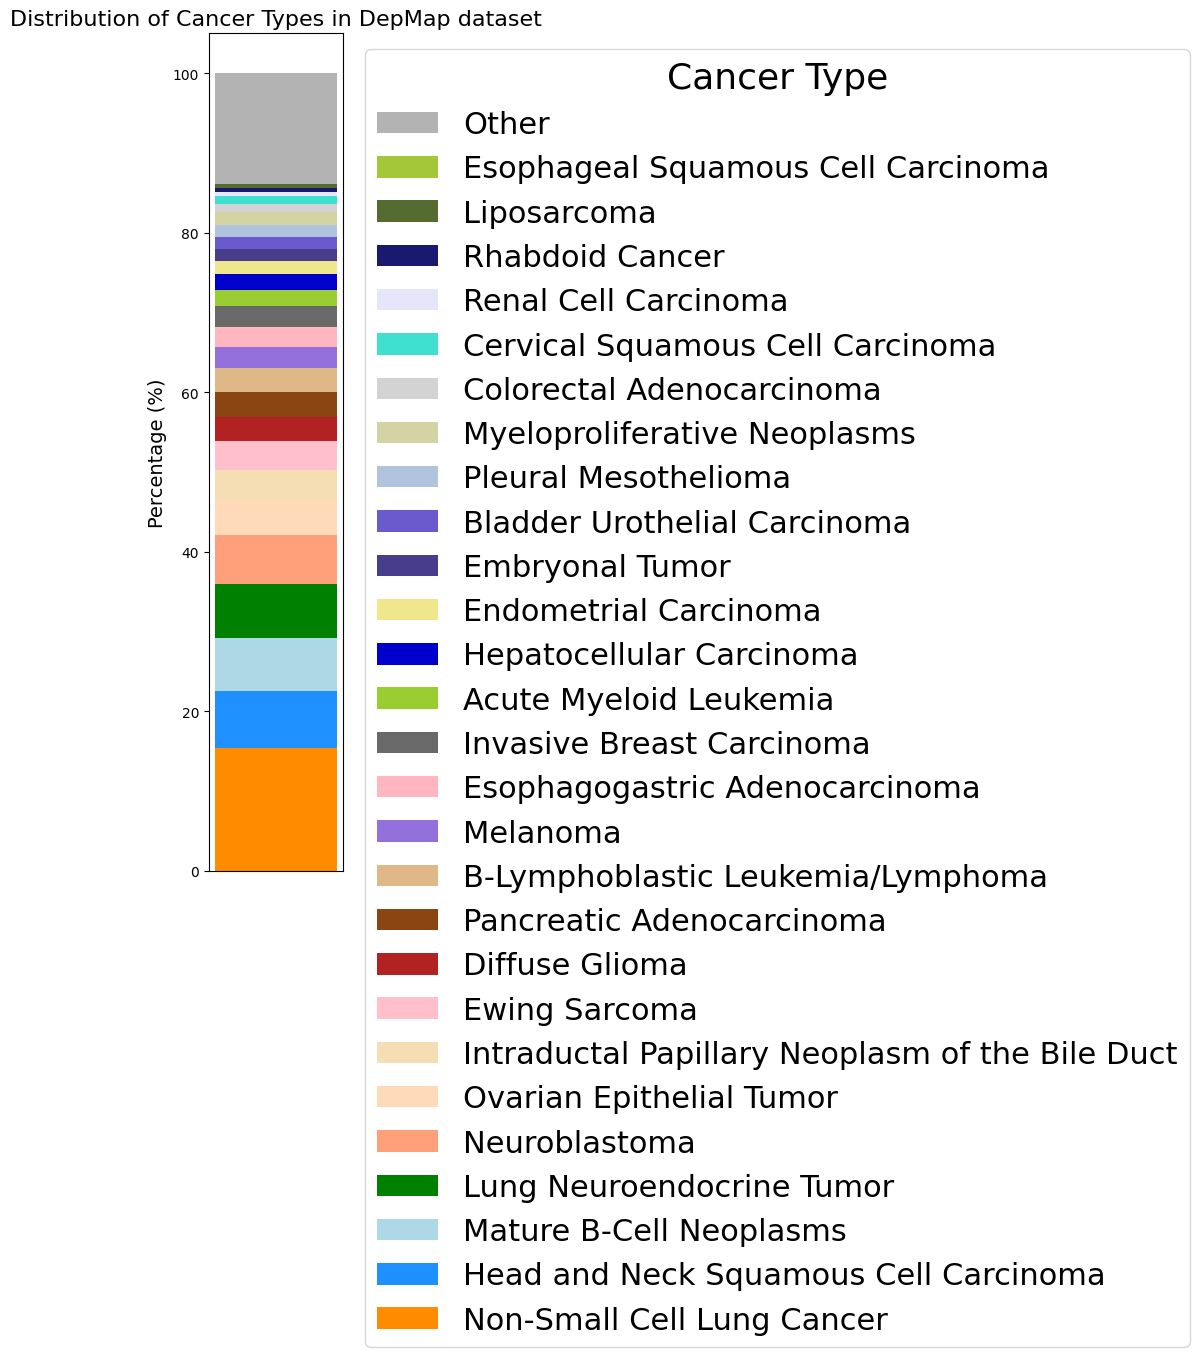

In [5]:
# List of cancer types in the REVERSED order from the image (bottom to top)
cancer_types = [
    "Other", # "Other" will now be at the top
    "Head and Neck Squamous Cell Carcinoma",
    "Mature B-Cell Neoplasms",
    "Non-Small Cell Lung Cancer",
    "Ovarian Epithelial Tumor",
    "Lung Neuroendocrine Tumor",
    "Intraductal Papillary Neoplasm of the Bile Duct",
    "Diffuse Glioma",
    "Neuroblastoma",
    "Melanoma",
    "Renal Cell Carcinoma",
    "Pancreatic Adenocarcinoma",
    "B-Lymphoblastic Leukemia/Lymphoma",
    "Ewing Sarcoma",
    "Esophagogastric Adenocarcinoma",
    "Invasive Breast Carcinoma",
    "Colorectal Adenocarcinoma",
    "Acute Myeloid Leukemia",
    "Endometrial Carcinoma",
    "Cervical Squamous Cell Carcinoma",
    "Embryonal Tumor",
    "Rhabdoid Cancer",
    "Hepatocellular Carcinoma",
    "Bladder Urothelial Carcinoma",
    "Pleural Mesothelioma",
    "Liposarcoma",
    "Myeloproliferative Neoplasms",
    "Esophageal Squamous Cell Carcinoma"
]

# Pairs of genes for which we extracted the expression populations
gene_pairs = [
    ["SMARCA4", "EP300"],
    ["SMARCA2", "SMARCA4"],
    ["SMARCB1", "EP300"],
    ["ARID1A", "EP300"],
    ["ARID1B", "EP300"],
    ["ARID2", "EP300"],
    ["PBRM1", "EGFR"],
    ["BAP1", "EP300"],
    ["CREBBP", "HLA-DQA1"],
    ["EED", "TAF1D"],
    ["KMT2C", "SDHD"],
    ["KMT2D", "EP300"],
    ["SETD2", "FECH"]
]

# Calculate the percentage for "Other" category
other_percent = 0
for cancer, percent in percent_dict.items():
    if cancer not in [c for c in cancer_types if c != "Other"]:  # Skip "Other" in the check
        other_percent += percent

# Sort cancer types by prevalence
# First remove "Other" from the list
non_other_cancers = [c for c in cancer_types if c != "Other"]

# Sort non-other cancers by their values in percent_dict (most common first)
sorted_cancers = sorted(
    [c for c in non_other_cancers if c in percent_dict],
    key=lambda x: percent_dict.get(x, 0),
    reverse=True
)

# Add any cancers from the original list that weren't in percent_dict
missing_cancers = [c for c in non_other_cancers if c not in percent_dict]
sorted_cancers.extend(missing_cancers)

# Put "Other" at the beginning (will be at the top of stack visually)
sorted_cancer_types = ["Other"] + sorted_cancers

# Create a new dictionary with our specific categories and "Other" in the sorted order
plot_data = {}
for cancer in sorted_cancer_types:
    if cancer == "Other":
        plot_data[cancer] = other_percent
    elif cancer in percent_dict:
        plot_data[cancer] = percent_dict[cancer]
    else:
        plot_data[cancer] = 0  # In case any cancer from our list isn't in percent_dict

# Define colors for each cancer type (same as the image)
colors = {
    "Other": "#B3B3B3",  # Light gray
    "Esophageal Squamous Cell Carcinoma": "#A4C639",  # Light green 
    "Myeloproliferative Neoplasms": "#D3D3A4",  # Light olive
    "Liposarcoma": "#556B2F",  # Dark olive green
    "Pleural Mesothelioma": "#B0C4DE",  # Light steel blue
    "Bladder Urothelial Carcinoma": "#6A5ACD",  # Slate blue
    "Hepatocellular Carcinoma": "#0000CD",  # Medium blue
    "Rhabdoid Cancer": "#191970",  # Midnight blue
    "Embryonal Tumor": "#483D8B",  # Dark slate blue
    "Cervical Squamous Cell Carcinoma": "#40E0D0",  # Turquoise
    "Endometrial Carcinoma": "#F0E68C",  # Khaki
    "Acute Myeloid Leukemia": "#9ACD32",  # Yellow green
    "Colorectal Adenocarcinoma": "#D3D3D3",  # Light gray
    "Invasive Breast Carcinoma": "#696969",  # Dim gray
    "Esophagogastric Adenocarcinoma": "#FFB6C1",  # Light pink
    "Ewing Sarcoma": "#FFC0CB",  # Pink
    "B-Lymphoblastic Leukemia/Lymphoma": "#DEB887",  # Burlywood
    "Pancreatic Adenocarcinoma": "#8B4513",  # Saddle brown
    "Renal Cell Carcinoma": "#E6E6FA",  # Lavender
    "Melanoma": "#9370DB",  # Medium purple
    "Neuroblastoma": "#FFA07A",  # Light salmon
    "Diffuse Glioma": "#B22222",  # Firebrick
    "Intraductal Papillary Neoplasm of the Bile Duct": "#F5DEB3",  # Wheat
    "Lung Neuroendocrine Tumor": "#008000",  # Green
    "Ovarian Epithelial Tumor": "#FFDAB9",  # Peach puff
    "Non-Small Cell Lung Cancer": "#FF8C00",  # Dark orange
    "Mature B-Cell Neoplasms": "#ADD8E6",  # Light blue
    "Head and Neck Squamous Cell Carcinoma": "#1E90FF",  # Dodger blue
}

# Save the data for the cancer bar
cancer_bar_data = {
    'categories': list(plot_data.keys()),
    'values': [plot_data[category] for category in plot_data.keys()],
    'colors': [colors[category] for category in plot_data.keys()]
}

# Create a figure with a larger size to accommodate all labels
plt.figure(figsize=(3, 9))

# Reorder categories to put "Other" at the end (will be at the top visually)
categories = [cat for cat in list(plot_data.keys()) if cat != "Other"] + ["Other"]
values = [plot_data[category] for category in categories]
color_list = [colors[category] for category in categories]

# Create a stacked bar chart with a single bar
plt.bar(0, values[0], color=color_list[0], label=categories[0])
bottom_value = values[0]

for i in range(1, len(values)):
    plt.bar(0, values[i], bottom=bottom_value, color=color_list[i], label=categories[i])
    bottom_value += values[i]

# Remove x-axis labels
plt.xticks([])
plt.xlabel('')

# Add a title and y-axis label
plt.title('Distribution of Cancer Types in DepMap dataset', fontsize=16)
plt.ylabel('Percentage (%)', fontsize=14)

# Adjust layout to make room for the legend
plt.tight_layout()
plt.subplots_adjust(right=0.7)

# Create legend with flipped order to match the visual representation in the bars
handles, labels = plt.gca().get_legend_handles_labels()

# Reverse the handles and labels to match the visual stacking order
plt.legend(
    handles[::-1], labels[::-1],  # Reverse to match the visual order in the bars
    title="Cancer Type",
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    fontsize=22,
    title_fontsize=26,
    ncol=1
)

# Display the plot
plt.show()

In [6]:
# Calculate and print summary statistics
def print_summary_statistics():
    combined_df, _ = process_all_data()

    # Total number of cell lines
    total_cell_lines = combined_df['Count'].sum()
    print(f"Total number of cell lines: {total_cell_lines}")

    # Group by population and calculate percentages
    population_counts = combined_df.groupby('Population')['Count'].sum()
    for population, count in population_counts.items():
        percentage = (count / total_cell_lines) * 100
        print(f"{population} expression group: {count} cell lines ({percentage:.2f}%)")

    # Per-gene statistics
    gene_stats = combined_df.groupby(['Gene', 'Population'])['Count'].sum().unstack(fill_value=0)
    print("\nPer-gene statistics:")
    print(gene_stats)

    # Total cell lines per gene
    gene_totals = gene_stats.sum(axis=1)
    print("\nTotal cell lines per gene:")
    print(gene_totals)

    # Percentage of high and low expression per gene
    print("\nPercentage of high and low expression per gene:")
    for gene, row in gene_stats.iterrows():
        high_percentage = (row['High'] / row.sum()) * 100 if row.sum() > 0 else 0
        low_percentage = (row['Low'] / row.sum()) * 100 if row.sum() > 0 else 0
        print(f"{gene}: High = {high_percentage:.2f}%, Low = {low_percentage:.2f}%")

    # Percentages of cancer types for each high/low expression group of each gene
    print("\nPercentages of cancer types for each high/low expression group of each gene:")
    cancer_type_stats = combined_df.groupby(['Gene', 'Population', 'Disease'])['Count'].sum()
    for (gene, population), group in cancer_type_stats.groupby(level=[0, 1]):
        total = group.sum()
        print(f"\n{gene} ({population} expression):")
        for disease, count in group.items():
            percentage = (count / total) * 100 if total > 0 else 0
            print(f"  {disease}: {count} cell lines ({percentage:.2f}%)")

# Print the summary statistics
print_summary_statistics()

NameError: name 'process_all_data' is not defined

/tmp/ipykernel_7482/506616506.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_pop["CancerType"] = high_pop["OncotreePrimaryDisease"].apply(
/tmp/ipykernel_7482/506616506.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_pop["CancerType"] = low_pop["OncotreePrimaryDisease"].apply(
/tmp/ipykernel_7482/506616506.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

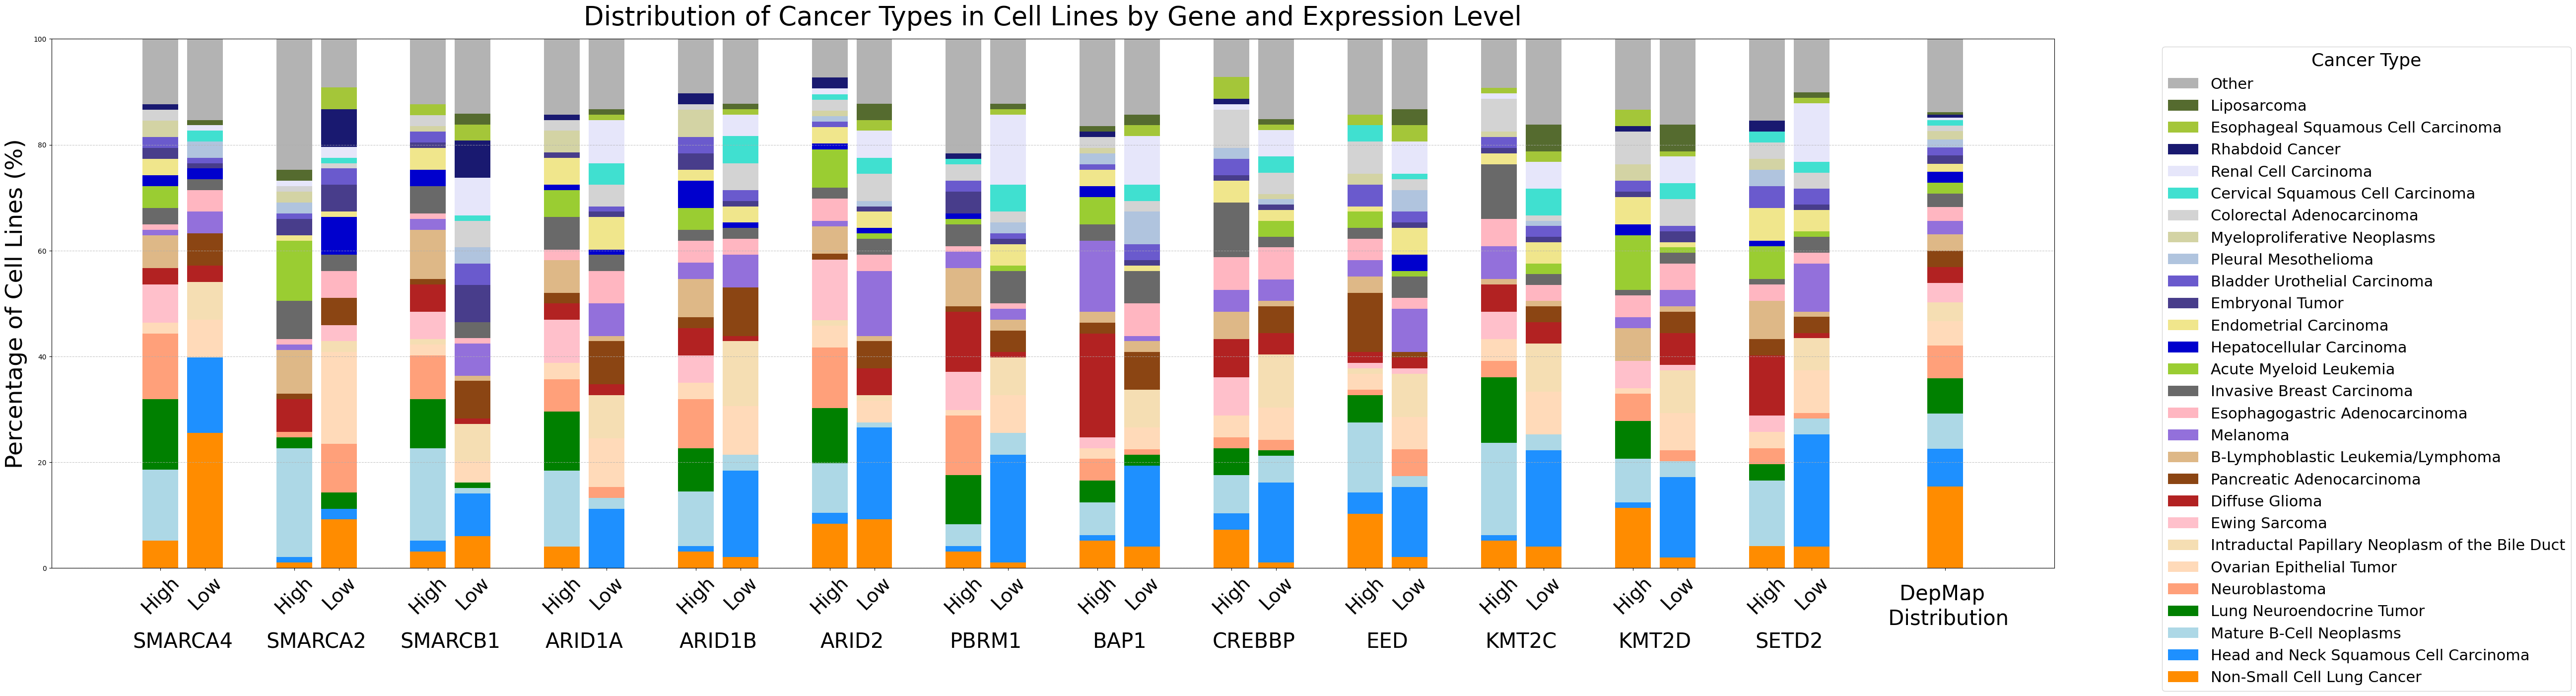

In [ ]:
def process_all_data():
    # Initialize dictionaries to store disease counts for both population types
    high_disease_counts = {}
    low_disease_counts = {}
    
    missing_files = []
    
    # List of predefined cancer types in the desired order
    cancer_types = [
        "Other", # "Other" will now be at the top
        "Head and Neck Squamous Cell Carcinoma",
        "Mature B-Cell Neoplasms",
        "Non-Small Cell Lung Cancer",
        "Ovarian Epithelial Tumor",
        "Lung Neuroendocrine Tumor",
        "Intraductal Papillary Neoplasm of the Bile Duct",
        "Diffuse Glioma",
        "Neuroblastoma",
        "Melanoma",
        "Renal Cell Carcinoma",
        "Pancreatic Adenocarcinoma",
        "B-Lymphoblastic Leukemia/Lymphoma",
        "Ewing Sarcoma",
        "Esophagogastric Adenocarcinoma",
        "Invasive Breast Carcinoma",
        "Colorectal Adenocarcinoma",
        "Acute Myeloid Leukemia",
        "Endometrial Carcinoma",
        "Cervical Squamous Cell Carcinoma",
        "Embryonal Tumor",
        "Rhabdoid Cancer",
        "Hepatocellular Carcinoma",
        "Bladder Urothelial Carcinoma",
        "Pleural Mesothelioma",
        "Liposarcoma",
        "Myeloproliferative Neoplasms",
        "Esophageal Squamous Cell Carcinoma"
    ]
    
    # Define colors for each cancer type
    colors = {
        "Other": "#B3B3B3",  # Light gray
        "Liposarcoma": "#556B2F",  # Dark olive green
        "Esophageal Squamous Cell Carcinoma": "#A4C639",  # Light green 
        "Rhabdoid Cancer": "#191970",  # Midnight blue
        "Renal Cell Carcinoma": "#E6E6FA",  # Lavender
        "Cervical Squamous Cell Carcinoma": "#40E0D0",  # Turquoise
        "Colorectal Adenocarcinoma": "#D3D3D3",  # Light grays
        "Myeloproliferative Neoplasms": "#D3D3A4",  # Light olive
        "Pleural Mesothelioma": "#B0C4DE",  # Light steel blue
        "Bladder Urothelial Carcinoma": "#6A5ACD",  # Slate blue
        "Embryonal Tumor": "#483D8B",  # Dark slate blue
        "Endometrial Carcinoma": "#F0E68C",  # Khaki
        "Hepatocellular Carcinoma": "#0000CD",  # Medium blue
        "Acute Myeloid Leukemia": "#9ACD32",  # Yellow green
        "Invasive Breast Carcinoma": "#696969",  # Dim gray
        "Esophagogastric Adenocarcinoma": "#FFB6C1",  # Light pink
        "Melanoma": "#9370DB",  # Medium purple
        "B-Lymphoblastic Leukemia/Lymphoma": "#DEB887",  # Burlywood
        "Pancreatic Adenocarcinoma": "#8B4513",  # Saddle brown
        "Diffuse Glioma": "#B22222",  # Firebrick
        "Ewing Sarcoma": "#FFC0CB",  # Pink
        "Intraductal Papillary Neoplasm of the Bile Duct": "#F5DEB3",  # Wheat
        "Ovarian Epithelial Tumor": "#FFDAB9",  # Peach puff
        "Neuroblastoma": "#FFA07A",  # Light salmon
        "Lung Neuroendocrine Tumor": "#008000",  # Green
        "Mature B-Cell Neoplasms": "#ADD8E6",  # Light blue
        "Head and Neck Squamous Cell Carcinoma": "#1E90FF",  # Dodger blue
        "Non-Small Cell Lung Cancer": "#FF8C00",  # Dark orange
    }
    
    # Process each file and count occurrences of OncotreePrimaryDisease for both population types
    for pair in gene_pairs:
        filename = f"inputs/expression_populations_{pair[0]}_{pair[1]}.csv"
        try:
            expression_populations = pd.read_csv(filename)
            
            # Merge with model data to get disease information
            full_dataset = pd.merge(
                left=expression_populations, 
                right=model, 
                how="left", 
                left_on="line", 
                right_on="ModelID"
            )
            
            # Get disease counts for high population
            high_pop = full_dataset[full_dataset["population"] == "high"]
            # Map diseases not in our predefined list to "Other"
            high_pop["CancerType"] = high_pop["OncotreePrimaryDisease"].apply(
                lambda x: x if x in cancer_types else "Other"
            )
            high_pop_count = high_pop["CancerType"].value_counts()
            
            # Get disease counts for low population
            low_pop = full_dataset[full_dataset["population"] == "low"]
            # Map diseases not in our predefined list to "Other"
            low_pop["CancerType"] = low_pop["OncotreePrimaryDisease"].apply(
                lambda x: x if x in cancer_types else "Other"
            )
            low_pop_count = low_pop["CancerType"].value_counts()
            
            # Store the final counts
            high_disease_counts[pair[0]] = high_pop_count
            low_disease_counts[pair[0]] = low_pop_count
            
        except FileNotFoundError:
            missing_files.append(f"{pair[0]}_{pair[1]}")
            continue
    
    if missing_files:
        print(f"Warning: Could not find {len(missing_files)} files: {', '.join(missing_files)}")
    
    if not high_disease_counts or not low_disease_counts:
        raise ValueError("No data found for any gene pairs. Check file paths and names.")
    
    # Convert to DataFrames
    high_df = pd.DataFrame(high_disease_counts).fillna(0)
    high_df.index.name = 'Disease'
    
    low_df = pd.DataFrame(low_disease_counts).fillna(0)
    low_df.index.name = 'Disease'
    
    # Melt for combined plotting
    high_melted = high_df.reset_index().melt(
        id_vars="Disease", 
        var_name="Gene", 
        value_name="Count"
    )
    high_melted["Population"] = "High"
    
    low_melted = low_df.reset_index().melt(
        id_vars="Disease", 
        var_name="Gene", 
        value_name="Count"
    )
    low_melted["Population"] = "Low"
    
    combined_df = pd.concat([high_melted, low_melted], ignore_index=True)
    
    return combined_df, cancer_types, colors

def create_modified_combined_plot():
    combined_df, cancer_types, color_dict = process_all_data()
    
    # Set figure size
    plt.figure(figsize=(52, 14))
    
    # Get the unique genes in the original order from gene_pairs
    gene_names = []
    for pair in gene_pairs:
        if pair[0] not in gene_names and pair[0] in combined_df["Gene"].unique():
            gene_names.append(pair[0])
    
    # We need two bars per gene with a small gap between them, and a larger gap between genes
    bar_width = 0.8
    group_gap = 1  # Gap between high/low pairs
    
    # Create positions for each bar
    positions = []
    high_low_labels = []
    gene_labels = []
    
    for i, gene in enumerate(gene_names):
        # Position for this gene's high expression bar
        pos_high = i * (2 + group_gap)
        positions.append(pos_high)
        high_low_labels.append("High")
        
        # Position for this gene's low expression bar
        pos_low = pos_high + 1
        positions.append(pos_low)
        high_low_labels.append("Low")
        
        # Add gene label centered between high and low bars
        gene_labels.append((pos_high + pos_low) / 2)
    
    # Add positions for the cancer distribution bar (at the end)
    last_position = positions[-1] + 2 + group_gap  # Extra gap after the last gene
    positions.append(last_position)
    high_low_labels.append("")  # Add one more label to match positions
    
    # Calculate total count for each position (high/low for each gene)
    total_counts = {}
    for i, gene in enumerate(gene_names):
        # Calculate total for high expression
        high_total = combined_df[(combined_df["Gene"] == gene) & 
                               (combined_df["Population"] == "High")]["Count"].sum()
        total_counts[(gene, "High")] = high_total
        
        # Calculate total for low expression
        low_total = combined_df[(combined_df["Gene"] == gene) & 
                              (combined_df["Population"] == "Low")]["Count"].sum()
        total_counts[(gene, "Low")] = low_total
    
    # Use the exact same order as defined in the colors dictionary for all bars
    ordered_cancer_types = list(color_dict.keys())
    
    # For gene bars, reverse the order (except "Other") to flip them
    gene_plot_order = []
    for cancer in reversed(ordered_cancer_types):
        if cancer != "Other":
            gene_plot_order.append(cancer)
    # Add "Other" at the end (top) of the list
    gene_plot_order.append("Other")
    
    # Plot the stacked bars as percentages
    bottoms = np.zeros(len(positions) - 1)  # Excluding the last position for now
    
    # First plot all categories except "Other" for gene bars in reversed order
    for disease in gene_plot_order:
        if disease == "Other":
            continue  # Skip "Other" for now, we'll add it at the very end
        
        percentage_heights = []
        
        for i, gene in enumerate(gene_names):
            # Get percentage for high expression
            high_count = combined_df[(combined_df["Gene"] == gene) & 
                                   (combined_df["Population"] == "High") & 
                                   (combined_df["Disease"] == disease)]["Count"].values
            high_value = high_count[0] if len(high_count) > 0 else 0
            high_percentage = (high_value / total_counts[(gene, "High")]) * 100 if total_counts[(gene, "High")] > 0 else 0
            percentage_heights.append(high_percentage)
            
            # Get percentage for low expression
            low_count = combined_df[(combined_df["Gene"] == gene) & 
                                  (combined_df["Population"] == "Low") & 
                                  (combined_df["Disease"] == disease)]["Count"].values
            low_value = low_count[0] if len(low_count) > 0 else 0
            low_percentage = (low_value / total_counts[(gene, "Low")]) * 100 if total_counts[(gene, "Low")] > 0 else 0
            percentage_heights.append(low_percentage)
        
        plt.bar(positions[:-1], percentage_heights, bottom=bottoms, width=bar_width, 
                label=disease, color=color_dict.get(disease, "#999999"))  # Default color if not in dict
        bottoms += percentage_heights
    
    # Now add "Other" at the top of all gene bars
    disease = "Other"
    percentage_heights = []
    
    for i, gene in enumerate(gene_names):
        # Get percentage for high expression
        high_count = combined_df[(combined_df["Gene"] == gene) & 
                               (combined_df["Population"] == "High") & 
                               (combined_df["Disease"] == disease)]["Count"].values
        high_value = high_count[0] if len(high_count) > 0 else 0
        high_percentage = (high_value / total_counts[(gene, "High")]) * 100 if total_counts[(gene, "High")] > 0 else 0
        percentage_heights.append(high_percentage)
        
        # Get percentage for low expression
        low_count = combined_df[(combined_df["Gene"] == gene) & 
                              (combined_df["Population"] == "Low") & 
                              (combined_df["Disease"] == disease)]["Count"].values
        low_value = low_count[0] if len(low_count) > 0 else 0
        low_percentage = (low_value / total_counts[(gene, "Low")]) * 100 if total_counts[(gene, "Low")] > 0 else 0
        percentage_heights.append(low_percentage)
    
    plt.bar(positions[:-1], percentage_heights, bottom=bottoms, width=bar_width, 
            label=disease, color=color_dict.get(disease, "#999999"))
    
    # Prepare DepMap reference percentages - replace these with actual values
    depmap_percentages = {
        "Head and Neck Squamous Cell Carcinoma": 3.5,
        "Mature B-Cell Neoplasms": 4.2,
        "Non-Small Cell Lung Cancer": 8.1,
        "Other": 5.0
    }
    
    # Create data for the right-most stacked bar (DepMap distribution)
    # Use the exact same order as defined in the colors dictionary
    ordered_cancer_types_for_depmap = list(color_dict.keys())  # This gets the order from the colors dict
    
    cancer_bar_data = {
        'categories': ordered_cancer_types_for_depmap,
        'values': [depmap_percentages.get(cancer, 1.0) for cancer in ordered_cancer_types_for_depmap],
        'colors': [color_dict.get(cancer, "#999999") for cancer in ordered_cancer_types_for_depmap]
    }
    
    # Call the function to create the stacked bar for cancer distribution
    create_stacked_bar(position=last_position, width=bar_width)
    
    # Customize the plot
    plt.xticks(positions, high_low_labels, fontsize=28, rotation=45, ha='center')
    plt.ylabel("Percentage of Cell Lines (%)", fontsize=34, labelpad=9)
    plt.title("Distribution of Cancer Types in Cell Lines by Gene and Expression Level", fontsize=38, pad=20)
    plt.ylim(0, 100)  # Set y-axis to 0-100% for percentages
    
    # Add gene labels below the high/low labels with extra spacing
    for i, gene in enumerate(gene_names):
        plt.text(gene_labels[i], -12, gene, ha='center', va='top', fontsize=30, rotation=0, transform=plt.gca().transData)
    
    # Add a label for the cancer distribution bar
    plt.text(last_position, -3, "DepMap \n Distribution", ha='center', va='top', fontsize=30, rotation=0, transform=plt.gca().transData)
    
    # Add grid lines for readability
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Create legend with reversed order to match bar stacking
    handles, labels = plt.gca().get_legend_handles_labels()
    
    # Add the legend for the disease colors
    plt.legend(
        handles[::-1], labels[::-1],  # Reverse here to match the visual stacking order 
        title="Cancer Type",
        bbox_to_anchor=(1.05, 1),
        loc='upper left',
        fontsize=22,
        title_fontsize=26,
        ncol=1
    )
    
    # Improve spacing
    plt.tight_layout()
    
    # Save the figure
    plt.savefig("combined_population_disease_distribution_percentage_consistent.png", dpi=300, bbox_inches="tight")
    
    return plt.gcf()

# Define the create_stacked_bar function that properly handles the order
def create_stacked_bar(position=0, width=0.8):
    # Get the categories, values and colors from the cancer_bar_data
    categories = cancer_bar_data['categories']
    values = cancer_bar_data['values']
    colors = cancer_bar_data['colors']
    
    # Plot in the exact order of the colors dictionary
    # With one special case - we'll save Other and plot it last (at the top)
    bottom_value = 0
    other_value = 0
    other_color = None
    
    # First plot everything EXCEPT "Other"
    for i in range(len(categories)):
        if categories[i] == "Other":
            other_value = values[i]
            other_color = colors[i]
            continue
        plt.bar(position, values[i], bottom=bottom_value, width=width, color=colors[i])
        bottom_value += values[i]
    
    # Now add "Other" at the top
    plt.bar(position, other_value, bottom=bottom_value, width=width, color=other_color)
    
    return bottom_value + other_value  # Total height of the bar

# Generate the combined plot
combined_figure = create_modified_combined_plot()
plt.show()

In [8]:
# Calculate and print summary statistics with means and standard deviations
def print_enhanced_summary_statistics():
    combined_df, cancer_types, color_dict = process_all_data() 
    
    # Total number of cell lines
    total_cell_lines = combined_df['Count'].sum()
    print(f"Total number of cell lines: {total_cell_lines}")

    # Group by population and calculate percentages
    population_counts = combined_df.groupby('Population')['Count'].sum()
    for population, count in population_counts.items():
        percentage = (count / total_cell_lines) * 100
        print(f"{population} expression group: {count} cell lines ({percentage:.2f}%)")

    # Per-gene statistics
    gene_stats = combined_df.groupby(['Gene', 'Population'])['Count'].sum().unstack(fill_value=0)
    print("\nPer-gene statistics:")
    print(gene_stats)

    # Total cell lines per gene
    gene_totals = gene_stats.sum(axis=1)
    print("\nTotal cell lines per gene:")
    print(gene_totals)

    # Percentage of high and low expression per gene
    print("\nPercentage of high and low expression per gene:")
    for gene, row in gene_stats.iterrows():
        high_percentage = (row['High'] / row.sum()) * 100 if row.sum() > 0 else 0
        low_percentage = (row['Low'] / row.sum()) * 100 if row.sum() > 0 else 0
        print(f"{gene}: High = {high_percentage:.2f}%, Low = {low_percentage:.2f}%")

    # Calculate mean and standard deviation for each cancer type's prevalence
    print("\n*** CANCER TYPE STATISTICS ***")
    print("\nMean and standard deviation of cancer type prevalence across genes:")
    
    # Create dictionaries to store percentage data for each cancer type
    high_percentages = {disease: [] for disease in cancer_types}
    low_percentages = {disease: [] for disease in cancer_types}
    
    # Calculate percentages for each gene and cancer type
    for gene in combined_df['Gene'].unique():
        high_counts = combined_df[(combined_df['Gene'] == gene) & (combined_df['Population'] == 'High')]
        low_counts = combined_df[(combined_df['Gene'] == gene) & (combined_df['Population'] == 'Low')]
        
        high_total = high_counts['Count'].sum()
        low_total = low_counts['Count'].sum()
        
        if high_total > 0:
            for disease in cancer_types:
                disease_count = high_counts[high_counts['Disease'] == disease]['Count'].sum()
                percentage = (disease_count / high_total) * 100
                high_percentages[disease].append(percentage)
        
        if low_total > 0:
            for disease in cancer_types:
                disease_count = low_counts[low_counts['Disease'] == disease]['Count'].sum()
                percentage = (disease_count / low_total) * 100
                low_percentages[disease].append(percentage)
    
    # Print mean and standard deviation for HIGH expression group
    print("\nHIGH EXPRESSION GROUP:")
    sorted_diseases_high = sorted(
        [(disease, np.mean(high_percentages[disease]), np.std(high_percentages[disease])) 
         for disease in cancer_types if high_percentages[disease]],
        key=lambda x: x[1],
        reverse=True
    )
    
    for disease, mean, std in sorted_diseases_high:
        if mean >= 1.0:  # Only show cancer types with at least 1% mean representation
            print(f"  {disease}: {mean:.2f}% ± {std:.2f}%")
    
    # Print mean and standard deviation for LOW expression group
    print("\nLOW EXPRESSION GROUP:")
    sorted_diseases_low = sorted(
        [(disease, np.mean(low_percentages[disease]), np.std(low_percentages[disease])) 
         for disease in cancer_types if low_percentages[disease]],
        key=lambda x: x[1],
        reverse=True
    )
    
    for disease, mean, std in sorted_diseases_low:
        if mean >= 1.0:  # Only show cancer types with at least 1% mean representation
            print(f"  {disease}: {mean:.2f}% ± {std:.2f}%")
    
    # Compare HIGH vs LOW for each cancer type
    print("\nCOMPARISON OF HIGH vs LOW EXPRESSION GROUPS BY CANCER TYPE:")
    cancer_comparisons = []
    
    for disease in cancer_types:
        if high_percentages[disease] and low_percentages[disease]:
            high_mean = np.mean(high_percentages[disease])
            low_mean = np.mean(low_percentages[disease])
            difference = high_mean - low_mean
            # Calculate p-value using t-test
            if len(high_percentages[disease]) > 1 and len(low_percentages[disease]) > 1:
                from scipy import stats
                t_stat, p_value = stats.ttest_ind(high_percentages[disease], low_percentages[disease], equal_var=False)
                significant = "significant" if p_value < 0.05 else "not significant"
                cancer_comparisons.append((disease, difference, p_value, high_mean, low_mean))
    
    # Sort by absolute difference
    cancer_comparisons.sort(key=lambda x: abs(x[1]), reverse=True)
    
    for disease, diff, p_value, high_mean, low_mean in cancer_comparisons:
        if abs(diff) >= 1.0 and (high_mean >= 1.0 or low_mean >= 1.0):  # Only show meaningful differences
            direction = "higher" if diff > 0 else "lower"
            significance = "*" if p_value < 0.05 else ""
            print(f"  {disease}: {abs(diff):.2f}pp {direction} in high expression (p={p_value:.4f}){significance}")
    
    # Percentages of cancer types for each high/low expression group of each gene
    print("\nPercentages of cancer types for each high/low expression group of each gene:")
    cancer_type_stats = combined_df.groupby(['Gene', 'Population', 'Disease'])['Count'].sum()
    for (gene, population), group in cancer_type_stats.groupby(level=[0, 1]):
        total = group.sum()
        print(f"\n{gene} ({population} expression):")
        sorted_group = group.sort_values(ascending=False)
        for disease, count in sorted_group.items():
            percentage = (count / total) * 100 if total > 0 else 0
            if percentage >= 1.0:  # Only show cancer types with at least 1% representation
                print(f"  {disease}: {count} cell lines ({percentage:.2f}%)")

# Print the enhanced summary statistics
print_enhanced_summary_statistics()

/tmp/ipykernel_7482/506616506.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_pop["CancerType"] = high_pop["OncotreePrimaryDisease"].apply(
/tmp/ipykernel_7482/506616506.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_pop["CancerType"] = low_pop["OncotreePrimaryDisease"].apply(
/tmp/ipykernel_7482/506616506.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

Total number of cell lines: 2541.0
High expression group: 1262.0 cell lines (49.67%)
Low expression group: 1279.0 cell lines (50.33%)

Per-gene statistics:
Population  High   Low
Gene                  
ARID1A      98.0  98.0
ARID1B      97.0  98.0
ARID2       96.0  98.0
BAP1        97.0  98.0
CREBBP      97.0  99.0
EED         98.0  98.0
KMT2C       97.0  99.0
KMT2D       97.0  99.0
PBRM1       97.0  98.0
SETD2       97.0  99.0
SMARCA2     97.0  98.0
SMARCA4     97.0  98.0
SMARCB1     97.0  99.0

Total cell lines per gene:
Gene
ARID1A     196.0
ARID1B     195.0
ARID2      194.0
BAP1       195.0
CREBBP     196.0
EED        196.0
KMT2C      196.0
KMT2D      196.0
PBRM1      195.0
SETD2      196.0
SMARCA2    195.0
SMARCA4    195.0
SMARCB1    196.0
dtype: float64

Percentage of high and low expression per gene:
ARID1A: High = 50.00%, Low = 50.00%
ARID1B: High = 49.74%, Low = 50.26%
ARID2: High = 49.48%, Low = 50.52%
BAP1: High = 49.74%, Low = 50.26%
CREBBP: High = 49.49%, Low = 50.51%
EED: